## Importing the libraries

In [45]:
import numpy as np 
import idx2numpy 
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns

## Importing the dataset

In [18]:
train_array = idx2numpy.convert_from_file('../input/train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('../input/train-labels-idx1-ubyte')
test_array = idx2numpy.convert_from_file('../input/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('../input/t10k-labels-idx1-ubyte')

In [19]:
train_array = train_array/255.0
test_array = test_array/255.0
train_array = np.expand_dims(train_array,1)
test_array = np.expand_dims(test_array,1)

In [20]:
num_train = len(train_array)
valid_size = 0.2 
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(num_train**valid_size))
train_idx,valid_idx = indices[split:],indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [21]:
train_array = torch.tensor(train_array,dtype=torch.float)
test_array = torch.tensor(test_array,dtype=torch.float)
train_labels = torch.tensor(train_labels,dtype=torch.long)
test_labels = torch.tensor(test_labels,dtype=torch.long)

In [22]:
train_data = TensorDataset(train_array,train_labels)
test_data = TensorDataset(test_array,test_labels)

In [23]:
train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=1)

In [24]:
train_image,train_target = next(iter(train_loader))
train_image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(576,256)
        self.fc2 = nn.Linear(256,10)

        self.dropout = nn.Dropout(0.2)


    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0],-1)
        x =self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x

model = Net()
print(model)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [35]:
# No of epochs 
n_epochs = 30 
# Tracking valid Loss 
valid_loss_min = np.Inf 
for epoch in range(1,n_epochs+1):
    train_loss = 0.0 
    valid_loss = 0.0
    model.train()
    for data,target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    model.eval()
    for data,target in valid_loader:
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)

    train_loss  = train_loss/len(train_loader.sampler)
    valid_loss  = valid_loss/len(valid_loader.sampler)

    print('Epoch: {}, Train Loss: {:.6f}, Valid Loss: {:.6f}'.format(epoch,train_loss,valid_loss))

    # Saving the model 
    if valid_loss<=valid_loss_min:
        print('Valid Loss has decreased from {:.6f} ---> {:.6f}.  Saving the model '.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(),'../models/model_mnist_cnn.pt')
        valid_loss_min=valid_loss


Epoch: 1, Train Loss: 2.301311, Valid Loss: 2.298259
Valid Loss has decreased from inf ---> 2.298259.  Saving the model 
Epoch: 2, Train Loss: 2.297225, Valid Loss: 2.280469
Valid Loss has decreased from 2.298259 ---> 2.280469.  Saving the model 
Epoch: 3, Train Loss: 2.007844, Valid Loss: 1.555775
Valid Loss has decreased from 2.280469 ---> 1.555775.  Saving the model 
Epoch: 4, Train Loss: 1.695505, Valid Loss: 1.536356
Valid Loss has decreased from 1.555775 ---> 1.536356.  Saving the model 
Epoch: 5, Train Loss: 1.637353, Valid Loss: 1.501199
Valid Loss has decreased from 1.536356 ---> 1.501199.  Saving the model 
Epoch: 6, Train Loss: 1.616890, Valid Loss: 1.519819
Epoch: 7, Train Loss: 1.606327, Valid Loss: 1.466183
Valid Loss has decreased from 1.501199 ---> 1.466183.  Saving the model 
Epoch: 8, Train Loss: 1.598798, Valid Loss: 1.461938
Valid Loss has decreased from 1.466183 ---> 1.461938.  Saving the model 
Epoch: 9, Train Loss: 1.594393, Valid Loss: 1.492246
Epoch: 10, Train 

In [36]:
model.load_state_dict(torch.load('../models/model_mnist_cnn.pt'))

<All keys matched successfully>

In [38]:
test_loss=0.0
y_pred = [] 
model.eval()
for data,target in test_loader:
    output = model(data)
    loss = criterion(output,target)
    _,pred = torch.max(output,1)
    y_pred.append(pred)
    test_loss+=loss.item()*data.size(0)

print('Test Loss: {:.6f}'.format(test_loss/len(test_loader.sampler)))

Test Loss: 1.474594


In [43]:
print(accuracy_score(test_labels,y_pred)*100)

98.68


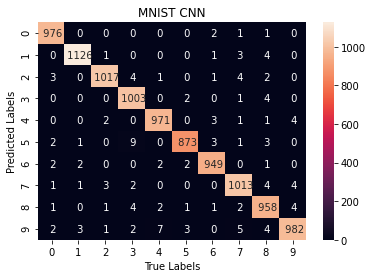

In [46]:
cm = confusion_matrix(test_labels,y_pred)
ax = sns.heatmap(cm,annot=True,fmt=' ')
ax.set_title('MNIST CNN')
ax.set_xlabel('True Labels')
ax.set_ylabel('Predicted Labels');

In [47]:
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

